In [336]:
# Todo: 
#   There's some sort of bug where the trial is transitioned/closed multiple times. 
#   Base p23 n on p1-based power calculation (https://clincalc.com/stats/samplesize.aspx)
#   Model decision making agents -- hypers go with d.m. agents
#   At present, a pt can be treated with many drugs, including any number of drugs for the very same varient!
#       This leads to over-the-top improvments, although it's not entirely obvious that this isn't 
#       a perfectly plausible strategy (cf. the 9-component GBM treatment), esp. before particular 
#       precision treatments haven't been approved. There are several things we're ignoring, specifically
#       combined toxicity and drug interactions.
#   There's a bug where because of the order of ops, the pts can end up with health << 0 just before death
#   Allow "cures" (at present you only accrue variants, never lose them!) Maybe when healh == 1.0, clear varvac?
#   Maybe txs should stop having an effect; possibly bcs the disease mutates away from the target variant
#       to a new biomarker configuration. At present this makes no difference bcs we are assuming that we 
#       test on every cycle and treat to the results of the test (i.e., we "chase" the biomarkers). 
#       But more correctly we would treat with the same drug until it stops working.

using Random
using Distributions
using Printf
using CPUTime
using PyPlot; const plt = PyPlot

global gloglevel = 0
function log!(msg,lvl=0) 
    lvl >= gloglevel ? print(msg) : false
end

##########################################################################################
# Globals and Hyperparmaters:
##########################################################################################

# Values declared as hypers are stored in the ghyps dictionary. This makes it convenient to
# save them with run results, but makes access very slow, so use lets to pull them into local around
# inner loops. Each entry in the dict is a pair: [current_value, default_value]. In initialization 
# we call sethyps() to set the current values to either defaiults, or to user-given values.

global ghyps = Dict()

macro hyp(variable, value); ghyps[:($variable)] = [eval(:($value)),eval(:($value))]; end
macro hyp(variable); :(ghyps[($variable)][1]); end # You have to use :symbols to make this work

function sethyps(overrides) # overrides is, e.g.: [:foo, 5.2], which will override the default
    for (hyp, cd) in ghyps; cd[1]=cd[2]; end # First set everything to default
    for (hyp, newval) in overrides; ghyps[hyp][1]=newval; end # Now override anything requested
    # Now we have to compute computed hypers -- WWW Note that you can't override computed hypers 
    # bcs they get recomputed here! (Prob. should test for this and barf!)
    ghyps[:hkilledthresh][1]=@hyp(:npts)*@hyp(:txinventiondeathfraction)
    # For efficiency this replicates the printlevel test to block the whole loop (much ado ...)
    gloglevel <= 5 ? showhyps() : []
end
    
mshowhyps() = for (hyp, cd) in ghyps; @printf("%s=%s (default=%s)\n", hyp, cd[1], cd[2]) ; end

@hyp npts 30
@hyp nvs 10 # n variants describing a patient
@hyp nyears 50

# Only treat when you get below this level (FFF This should have measurement error!)
@hyp htxthresh 0.7

# Hypers for positive and negative effect sizes:
@hyp hesp Dict(:pm => 0.5, :pd => 0.1, :nm => -0.1, :nd => 0.1)

# Simplified Beta Hyper Parameters [alpha,beta]
@hyp hsbhps Dict(:farleftpeak => [1.5,20], :leftpeak => [3,11], :centered => [10,10], :rightpeak => [11,3])

# Get a mean and deviation (usually for normal sampling) centered at the keyed beta, and with the keyed deviation
BBMD(Mkey,Dkey) = rand(Beta(@hyp(:hsbhps)[Mkey][1],@hyp(:hsbhps)[Dkey][2])) # BetaBasedMandD

# !!! FFF !!! THESE SHOULD BE MOVED INTO INIT TO BE SET AT INIT TIME FFF !!!

# Variant occurrance dist (when sampled N>0.5)
# ??? Is this too meta? Could just take means from hyper consts rather than sampling them from betas.
@hyp hvopds [Normal(BBMD(:farleftpeak,:centered),BBMD(:leftpeak,:centered)) for i in 1:@hyp(:nvs)]

# Variant effect size (ves) is sampled from a bimodal mixture:
@hyp hmm MixtureModel(Normal[Normal(0.05, 0.01),Normal(0.2, 0.1)],[0.95,0.05])
# See the mixture: plt.hist(rand(hmm,1000),100)
@hyp hmmd 0.1 # Deviation for N effect sizes centered on mixture model samples (FFF??? Sample this too?)
@hyp vesds [Normal(rand(ghyps[:hmm][1]),ghyps[:hmmd][1]) for i in 1:ghyps[:nvs][1]]

function printvesds()
    log!("Variant effect size distributions:\n")
    for vesd in ghyps[:vesds][1]
        log!(@sprintf("%s\n",vesd))
    end
end

##########################################################################################
# Structs, Global stores, Creators, and Printers
##########################################################################################

# Pateints are described by binary variant vectors, beginning at [0,...,0] and collecting variants at
# the rate given by the variant occurrance probability (vop, per year==cycle). Each variant
# also has an effect size (ves), which actually the mean and sd of the gaussian effect size, again, per year. 
# So, as patients develop variants over time, their health, which begins at 1.0, starts declining in accord
# with collected variants. The trial could concienvably be a multie-tx field, but at the moment off-trial 
# treatments are one-shot and dependent on immediate variant tests, so we don't need to record txs other 
# than trials. The trial will be false if there's no trial.

mutable struct pt; id; health; varvec; history; trial; trial_cycles end
global gpts = []
ptfmt(pt) = @sprintf("{Pt#%2d=%.2f%s{%s}}",pt.id,pt.health,pt.varvec,ctfmt(pt.trial))

# A treatment (tx) is just the target variant (by index), an set of effect size distributions (normals), 
# and an approval status, which is either true, for an approved tx, false for a failed on, or 
# a clinical trial structure. We create a new targted tx is based on when the number of patients 
# to die with a particular variant reaches > some % of the population.
# The status will either be a trial, or true if it's approved
# Effect model (em): [[variant number, effect distrubution]...]
mutable struct tx; id; em; status; end
global gtxs = []
emfmt(em) = string(map(m->@sprintf("[%s,N%s]",m[1],params(m[2])),em))
txfmt(tx) = @sprintf("<Tx#%2d(%s):%s>",tx.id,ctshortfmt(tx.status),emfmt(tx.em))

# Clinical trials go trough 2 phases: 1 and 2/3 (23). The first phase seeks to power the second phase. When a new 
# drug is invented, it goes into a phase 1 trials, and can NOT be used except in the trial. Once it 
# passes phase 1 (if it does), it goes into a specifically-powered phase 23 trial. At THAT point, anyone
# can use the drug. Patients who are enrolled in either a phase 1 or phase 2 trial only get the trial
# treatment, whereas patients who are NOT in a trial can get any drug that is in phase 2 or beyond. 
# So an advantage of going into a phase 1 trials is that you get drug before anyone else. The disadvantage
# is that you're stuck with that one drug. One question is, why would anyone who could get the drug anyway,
# bother going into a phase 2/3 trial? The answer is that they wouldn't, but that's not the world we live in.
# So there is another factor, which is that any patient who CAN go into a trial MUST go into a trial (under the
# :strict policy). In :strict there is a health cutoff for the trial, which is based on the phase 1 analysis.
# Any patient with the target mutation who passes the health cutoff MUST (under :strict) go into the 23 trial.
# The :strict policy is actually more like the real world, and it's probably the comparison case. The other
# policy (:open), any can get any drug that has passes phase 1, and so there's no reason that anyone would 
# go into a phase 23 trial, when they can just get tested all the time, and get whatever drug they want, and
# any number of them, and change all the time. In fact, :open is to obviously better than :strict, and so not-
# the-way-the-world-really-is, that I haven't even bother to implement :open!

@hyp phase1_ptsneeded 3 # This looks like it shouldn't be a constant, but in practice, it actually is!
@hyp phase1_duration_per_patient 3 # FFF ??? Maybe go to dose escalation, or patient response
@hyp phase23_ptsneeded 3 # FFF Compute from Phase 1 results, see: https://clincalc.com/stats/samplesize.aspx
@hyp phase23_duration_per_patient 3 # FFF Ditto should be computed based on phase 1, although less critical than n
mutable struct ct; id; txs; pts; phase; ptsneeded; duration_per_patient; end
global gcts = []
ctfmt(ct) = @sprintf("[CT%2dph%d,n=%s]",ct.id,ct.phase,length(ct.pts))
ctfmt(status::Bool) = status
ctshortfmt(status::Bool) = status
ctshortfmt(ct) = @sprintf("[CT%2dp%d]",ct.id,ct.phase)
# ??? I tried this with nested maps but it didn't work.
report() = for (obs,fmtfn) in ((gpts, ptfmt),(gtxs,txfmt),(gcts,ctfmt)); map(ob->@printf("%s\n",fmtfn(ob)),obs); end
# Once phase 1 trials are completed, they get converted to phase23 and added to the phase23 list.
global phase23_trials = []
global completed_trials = [] 

##########################################################################################
# Variants (biomarkers)
##########################################################################################

# Variants are accrued randomly throughout life. 

# Variant occurs? predicate (i.e., > 0.5) => true/false
vop(vn) = (rand(@hyp(:hvopds)[vn]) > 0.5)

# Maybe gain a variant (nvs just passed in for efficiency so we don't have to @hyp it)
gainvars(varvec,nvs) = [((vop(vn) > 0.5) ? 1 : varvec[vn]) for vn in 1:nvs]

# Patient health hit is the amount to reduce the pt's health based on the sum of samples
# from all of the accrued variants. 
function varhealthhit(varvec)
    let vesds = @hyp(:vesds)
        #varhealthhit(varvec) = reduce(+,[varvec[vn]*rand(gvesds[vn]) for vn in 1:gnvs])
        reduce(+,[varvec[vn]*rand(vesds[vn]) for vn in 1:@hyp(:nvs)])
    end
end

##########################################################################################
# Treating and creating new treatments
##########################################################################################
@hyp txinventiondeathfraction 0.1
@hyp hkilledthresh 999999.999999 # Gets init'ed in init() [Needs to be same type to avoid conv errs]
@hyp hnewtxthresh 0.8

# Each time a new treatment is created, it is intially created in the context of a clinical trial,
# and as long as there is a trial for that treatment available, that's the preferred way to be treated.
# In a phase 1 trials, it's the ONLY way you can get treated, but once the trial is in phase 2/3 (23)
# anyone who is not in the trial's target model (meaning doesn't have the excluded variants), can get
# the treatment, but patients in the trial MUST stay on the trial regimen, whereas others can get the tx
# but aren't required to follow protocol if they end up not doing so well on the drug.

function mcantxs() # maybe create a new treatment
    # For each of the places where the counts of pts killed by particular variants > kill threshold
    # decide whether to create a tx, and create it. (Note that there can be more than one tx/variant!)
    let hkilledthresh = @hyp(:hkilledthresh), hnewtxthresh = @hyp(:hnewtxthresh) 
        killedpts = map(pt->pt.varvec,filter(pt->pt.health==0,gpts))
        killedpts != [] ? killedpts = reduce(+,killedpts) : []
        log!(@sprintf("Patient kill per variant counts: %s (hkilledthresh=%s)\n",killedpts, hkilledthresh))
        for vn in (killedpts != [] ? findall(x->x>hkilledthresh,killedpts) : []) 
            if rand(Normal())>hnewtxthresh # FFF Adjust up for the number of txs for this var already on the market!
                newtx(vn)
            end
        end
    end
end

# Although each new tx is targeted to a particular variant, we also create side-effect
# variant effects with a certain (small) probability. These are generally slightly negative,
# whereas 

function newtx(vn)  # FFF Rationalize the effect size, and add a clinical trial in the status
    # First is the main effect (generally +) and one side effect (-centered) FFF Makes these more flexible
    # (Also, the main effect and side effect could cancel if they are the same vn -- prob disallow this! FFF UUU)
    # Under one FFF theory, there should be a small side effect for EVERY vn -- too complex, maybe some day)
    # A new tx gets a phase 1 trial for just this treatment. FFF trials can be started for multiple
    # treatments through a different channel.
    let hesp = @hyp(:hesp) 
        ntx=tx(1+length(gtxs),[[vn,Normal(hesp[:pm],hesp[:pm])],[rand(1:@hyp(:nvs)),Normal(hesp[:nm],hesp[:nd])]],false)
        nct = ct(1+length(gcts),[ntx],[],1,@hyp(:phase1_ptsneeded),@hyp(:phase1_duration_per_patient))
        ntx.status=nct
        push!(gtxs,ntx)
        push!(gcts,nct)
        log!(@sprintf("Creating new tx: %s\n",txfmt(ntx)))
    end
end

# When you treat a patient, you treat every variant for which he has a positive test
# (tests are assumed to be correct! FFF: Probabalize tests!) If there are several possible
# approved treatments for a a given variant, you choose one uniformly at random.

function treat(pt)
    # If the patient is on a trial, the treatment is determined by the trial, 
    # otherwise, you can treat per variants
    ct = pt.trial
    if ct == false
        find_trial_or_freetreat(pt)
    else
        # Treat with the trail treatment, and then update the trial stats
        log!(@sprintf("Treating pt#%s on trial %s\n",pt.id,ct.id))
        treatwith(pt,ct.txs[1])
        # If the pt has been on the trial the required number of cycles, take them off
        if ct.duration_per_patient == pt.trial_cycles
            log!(@sprintf("Taking pt#%s off trial %s\n",pt.id,ct.id))
            # Nb. Taking a patient off a trial removes the trial from the patient record, but does not 
            # remove the patient from the TRIAL's record. We always remember which patients we treated on the trial
            pt.trial = false
            # Consider closing this trial if this is the last patient, and it's not already closed
            # Patients can still be on the trial even though it's technically closed.
            # No new ones can be recruited, but ones already on can be recruited.
            if (length(ct.pts)==ct.ptsneeded)
                # Okay, time to close the trial -- different logic for p1 and p23
                if ct.phase == 1
                    log!(@sprintf("Converting trial %s from phase 1 to phase 23\n",ct.id))
                    push!(phase23_trials,ct)
                    ct.phase = 23
                    ct.ptsneeded = @hyp(:phase23_ptsneeded)
                    # FFF !!! Compute from phase 1 variance: https://clincalc.com/stats/samplesize.aspx
                    ct.duration_per_patient == @hyp(:phase23_duration_per_patient)
                else
                    log!(@sprintf("Trial %s has been completed, approving %s!\n",ct.id, ct.txs[1].id))
                    push!(completed_trials,ct)
                    ct.txs[1].status = true # Mark this treatment as approved!
                end
            end
        else
            pt.trial_cycles = pt.trial_cycles + 1
        end
    end
end
        
function find_trial_or_freetreat(pt)
    # The number of patients needed for a trial is used to decide whether a trial is available
    # When phase 1 is done, the ptsneeeded will be reset to the appropriate number for p23, and will
    # again count up. Once the p23 trial is completed, the ptsneeded will be full up, and won't get
    # reset, so the trial will never be selected again.
    goodtrials = filter(ct->(applicabletxp(ct.txs[1],pt.varvec)&&(length(ct.pts)<ct.ptsneeded)),gcts) 
    if goodtrials != []
        ct = rand(goodtrials)
        pt.trial = ct
        pt.trial_cycles = 1
        ct.pts=cat(ct.pts,pt,dims=1)
        log!(@sprintf("Enrolled pt%s in trial %s\n",pt.id,ct.id))
        treat(pt)
    else
        log!(@sprintf("Free Treating pt#%s\n",pt.id))
        freetreat(pt)
    end
end
        
function applicabletxp(tx,varvec)
    # The first elt of the vn array is the target
    1==varvec[(map(vn_ves->vn_ves[1],tx.em))[1]]
end

# If we find a trial that this patient can go on, we do that, otherwise, we treat all the variants they have
# The treatment either has to have no attached trials, or anh attached trial must be in phase23. The reason we
# might get here even though there are trials for this vn, is that the available trials might be full up.

function freetreat(pt)
    for vn in findall(v->v==1,pt.varvec)
        # Find all possible treatments for this variant:
        # And then keep only those that aren't in a trial, or are in phase 23
        txs = filter(tx->(tx.status==true)||(tx.status.phase==23),filter(tx->[]!=findall(vn_ves->vn_ves[1]==vn,tx.em),gtxs))
        txs != [] ? treatwith(pt,txs[rand(1:end)]) : log!(@sprintf("No available treatments!\n"))
    end
end

# Treating a patient entails applying an effect size (es) sample from each of the applicable 
# effect models in the tx. Each em is a pair of a variant number and an effect distribution for that
# variant. Even though the variants are chosen to target one particular vn, all the vns that this pt
# has will be applied! This models side effects. 

function treatwith(pt,tx)
    log!(@sprintf("Treating pt#%s (%.2f) with %s\n",pt.id,pt.health,txfmt(tx)))
    for (vn,ves) in tx.em
        pt.varvec[vn]==1 ? pt.health=pt.health+rand(ves) : false # If this is a side effect, the dist will be negatively biased
    end
end


##########################################################################################
# Top Loop
##########################################################################################

function init(loglevel,overrides)
    # Clear collectors
    global gloglevel=loglevel
    global gpts = [pt(p, 1.0, [0 for i in 1:@hyp(:nvs)], [1.0], false, nothing) for p in 1:@hyp(:npts)] # not on any trials to begin with
    global gtxs = []
    global gcts = []
    global phase23_trials = []
    sethyps(overrides)
end

# Test shows lots of logging whereas run shows none, and averages the average mortalities over all runs.
# You can override any hyperparameter on either with overrides=[[:hyp,newval],...]
# ** Note that overrides, if you use them, have to be a list of lists, as: overrides=[[:foo,10],[:bar,20]]

function test(;overrides=[],loglevel=0,plot=true) # Watch as variants accrue and health declines
    init(loglevel,overrides)
    log!(printvesds())
    let nyears = @hyp(:nyears), htxthresh = @hyp(:htxthresh), nvs = @hyp(:nvs)
        for year in 1:nyears
            log!(@sprintf("\n-------- %s --------\n",year))
            for pt in gpts
                # There's a sort of which-comes-first problem here about changing health level, then zero'ing it out
                # if it's under 0, and then treating or not. Probably this logic could be simplified a bit FFF ???
                pt.varvec=gainvars(pt.varvec,nvs)
                (pt.health > 0) ? (pt.health=pt.health-varhealthhit(pt.varvec)) : false # Not sure why this syntax requires an else (:) ???
                # (FFF Probably do this with tanh instead of these hard limits?)
                (pt.health <= 0) ? (pt.health = 0) : (pt.health < htxthresh ? treat(pt) : false)
                (pt.health >= 1.0) ? (pt.health = 1.0) : false 
                push!(pt.history,pt.health)
            end
            mcantxs()
        # report()
        end
        if plot
            plt.plot([[[pt.history for pt in gpts][i][j] for i in 1:ghyps[:npts][1]] for j in 1:nyears]) # UUU Array rotation
            #plt.text(nyears-20,-0.2,"maybe add a label?")
            plt.ylabel("Health")
            plt.xlabel("Years from Diagnosis")
            show(ghyps)
        end
        return mean(map(pt->((last(pt.history)!=0.0) ? nyears : (findall(h->h==0.0,pt.history)[1]) ),gpts))
    end
end

function run(;n=10,overrides=[])
    let a = []
        for i in 1:n
            r=test(loglevel=99,overrides=overrides,plot=false)
            #@printf("%s:%s\n",i,r)
            push!(a,r)
        end
        return [mean(a),std(a)]
    end 
end
#run(n=10,overrides=[[:htxthresh,0.7]])
#test(overrides=[[:htxthresh,0.7]])

function srun(overkey,from,to,step;n=10,)
    local results = []
    let overrider = [[overkey,0.0]]
        for val in from:step:to
            overrider[1][2]=val
            result = run(n=n,overrides=overrider)
            @printf("@%s=%s:%s\n",overkey,val,result)
            push!(results,[val,result])
        end
    end
    let x=[x[1] for x in results], y=[x[2][1] for x in results]
        plt.scatter(x,y) 
        plt.plot(x,y) 
        plt.errorbar(x, y, yerr=[(x[2][2]/sqrt(n)) for x in results])
        plt.ylabel("Mean Survival")
        plt.xlabel(string(overkey))
    end
    return(results)
end
#srun(:txinventiondeathfraction,0.0,1.0,0.1)

srun (generic function with 3 methods)

@txinventiondeathfraction=0.0:[8.950000000000001, 0.716515918684571]
@txinventiondeathfraction=0.1:[8.309999999999999, 0.8403482523247046]
@txinventiondeathfraction=0.2:[7.609999999999999, 0.6679709463630773]
@txinventiondeathfraction=0.3:[8.186666666666667, 0.5533734925185905]
@txinventiondeathfraction=0.4:[7.4799999999999995, 0.5863046020796296]
@txinventiondeathfraction=0.5:[7.503333333333333, 0.5763765058910796]
@txinventiondeathfraction=0.6:[7.429999999999998, 0.52055288745907]
@txinventiondeathfraction=0.7:[7.296666666666665, 0.4164666186436128]
@

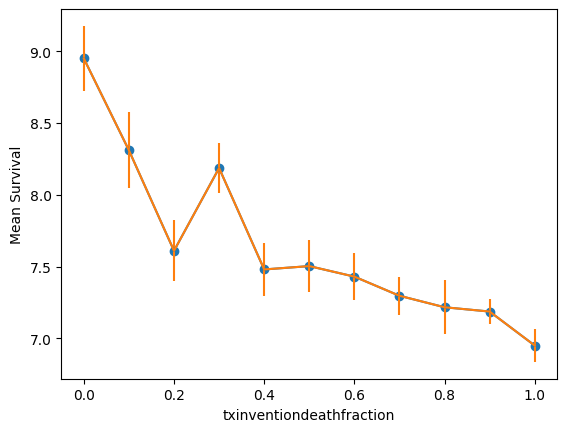

txinventiondeathfraction=0.8:[7.216666666666666, 0.5919730557765549]
@txinventiondeathfraction=0.9:[7.186666666666667, 0.27451416118546257]
@txinventiondeathfraction=1.0:[6.95, 0.36115384362544467]


11-element Array{Any,1}:
 Any[0.0, [8.950000000000001, 0.716515918684571]]
 Any[0.1, [8.309999999999999, 0.8403482523247046]]
 Any[0.2, [7.609999999999999, 0.6679709463630773]]
 Any[0.3, [8.186666666666667, 0.5533734925185905]]
 Any[0.4, [7.4799999999999995, 0.5863046020796296]]
 Any[0.5, [7.503333333333333, 0.5763765058910796]]
 Any[0.6, [7.429999999999998, 0.52055288745907]]
 Any[0.7, [7.296666666666665, 0.4164666186436128]]
 Any[0.8, [7.216666666666666, 0.5919730557765549]]
 Any[0.9, [7.186666666666667, 0.27451416118546257]]
 Any[1.0, [6.95, 0.36115384362544467]]

In [340]:
srun(:txinventiondeathfraction,0.0,1.0,0.1)

In [341]:
showhyps()

hnewtxthresh=0.8 (default=0.8)
nvs=10 (default=10)
hmm=MixtureModel{Normal}(K = 2)
components[1] (prior = 0.9500): Normal{Float64}(μ=0.05, σ=0.01)
components[2] (prior = 0.0500): Normal{Float64}(μ=0.2, σ=0.1)
 (default=MixtureModel{Normal}(K = 2)
components[1] (prior = 0.9500): Normal{Float64}(μ=0.05, σ=0.01)
components[2] (prior = 0.0500): Normal{Float64}(μ=0.2, σ=0.1)
)
phase1_ptsneeded=3 (default=3)
hesp=Dict(:pm => 0.5,:nm => -0.1,:pd => 0.1,:nd => 0.1) (default=Dict(:pm => 0.5,:nm => -0.1,:pd => 0.1,:nd => 0.1))
hmmd=0.1 (default=0.1)
phase23_ptsneeded=3 (default=3)
npts=30 (default=30)
nyears=50 (default=50)
hsbhps=Dict{Symbol,Array{T,1} where T}(:leftpeak => [3, 11],:centered => [10, 10],:rightpeak => [11, 3],:farleftpeak => [1.5, 20.0]) (default=Dict{Symbol,Array{T,1} where T}(:leftpeak => [3, 11],:centered => [10, 10],:rightpeak => [11, 3],:farleftpeak => [1.5, 20.0]))
phase23_duration_per_patient=3 (default=3)
txinventiondeathfraction=1.0 (default=0.1)
phase1_duration_per_pat